<a href="https://colab.research.google.com/github/FaQ2108/Personal_Projects/blob/main/Prediccion_Acciones_ARIMA_SARIMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Proyecto: Predicción de Precios de Acciones con Modelos ARIMA/SARIMA**
## 1. Descripción General
Este proyecto tiene como objetivo implementar modelos estadísticos ARIMA y SARIMA para predecir los precios de acciones a corto plazo. Los modelos de series temporales, como ARIMA y SARIMA, son herramientas populares para capturar patrones estacionales y tendencias en los datos financieros, permitiendo realizar predicciones fundamentadas en el comportamiento histórico de los precios.
## 2. Objetivo
* Aplicar los conceptos de análisis de series temporales en un contexto financiero.
* Explorar las fortalezas y limitaciones de los modelos ARIMA y SARIMA en la predicción de precios de acciones.
* Producir una predicción a corto plazo de los precios de una acción específica, basada en los datos históricos.


In [35]:
# Importar las librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import yfinance as yf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA

# Carga de datos históricos de precios de cierre de una acción específica
ticker = 'NVDA'  # Elegimos Ticker deseado, en este caso NVDA (NVIDIA)
data = yf.download(ticker, start='2020-01-01', end='2024-01-10')

[*********************100%***********************]  1 of 1 completed


In [36]:
# Seleccionamos solo la columna de precios de cierre
df = data['Close']
df = df.asfreq('D').fillna(method='ffill')

In [37]:
# Observamos brevemente la estructura de los datos:
df.head()

Ticker                        NVDA
Date                              
2020-01-02 00:00:00+00:00  5.99775
2020-01-03 00:00:00+00:00  5.90175
2020-01-04 00:00:00+00:00  5.90175
2020-01-05 00:00:00+00:00  5.90175
2020-01-06 00:00:00+00:00  5.92650

In [38]:
# Contamos la cantidad de registros.
df.shape

(1469, 1)

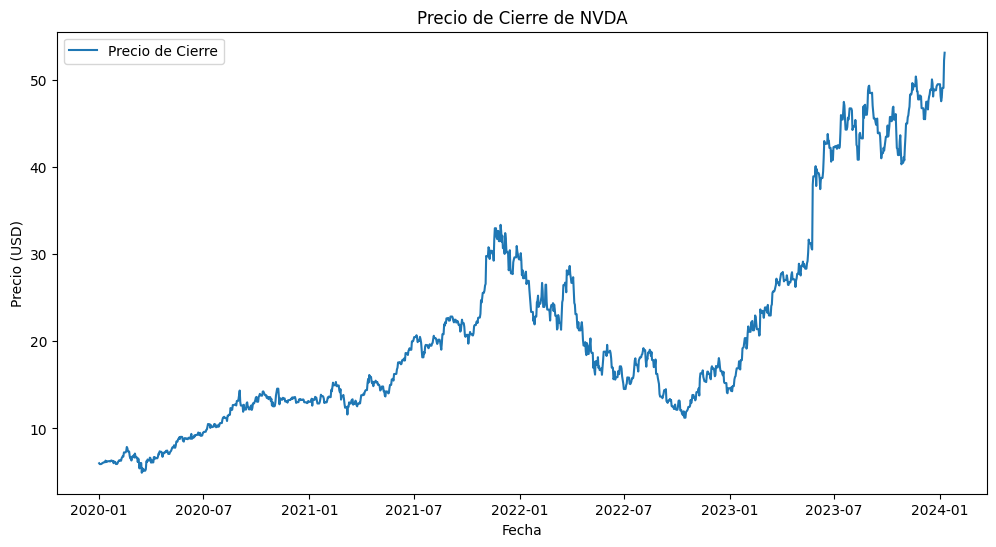

In [39]:
# Visualizamos los datos
plt.figure(figsize=(12, 6))
plt.plot(df, label='Precio de Cierre')
plt.title(f'Precio de Cierre de {ticker}')
plt.xlabel('Fecha')
plt.ylabel('Precio (USD)')
plt.legend()
plt.show()

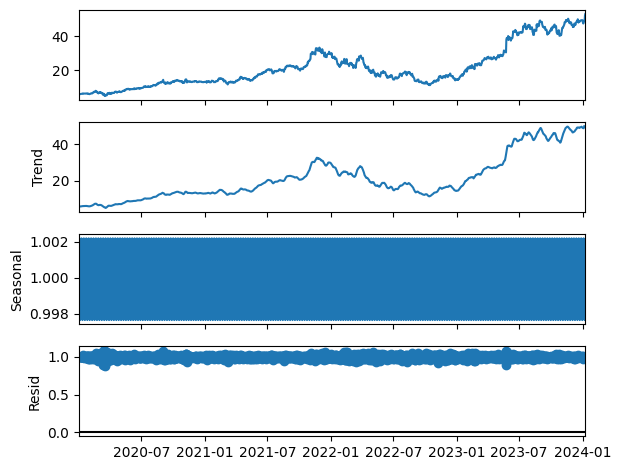

In [40]:
# Descomponemos la serie temporal para identificar componentes de tendencia, estacionalidad y residuales
decomposition = sm.tsa.seasonal_decompose(df, model='multiplicative')
fig = decomposition.plot()
plt.show()

In [41]:
# Realizamos prueba de Dickey-Fuller aumentada para verificar estacionariedad
from statsmodels.tsa.stattools import adfuller

result = adfuller(df.dropna())
print('ADF Statistic:', result[0])
print('p-value:', result[1])

ADF Statistic: 0.2852255898567059
p-value: 0.9766563984550442


Los valores obtenidos de la prueba de Dickey-Fuller aumentada (ADF) sugieren que la serie temporal no es estacionaria.

ADF Statistic: 0.2852: Un valor más cercano a cero indica que la serie temporal es estacionaria. En este caso, el valor es bastante alto, lo que sugiere que la serie no es estacionaria.

p-value: 0.9767: Un p-valor por encima de 0.05 significa que no podemos rechazar la hipótesis nula de que la serie tiene una raíz unitaria (no estacionaria).

Implicaciones:
Estos resultados indican que la serie temporal probablemente contiene una tendencia o algún componente estacional.

ADF Statistic: -11.256145097219264
p-value: 1.6652651630582482e-20


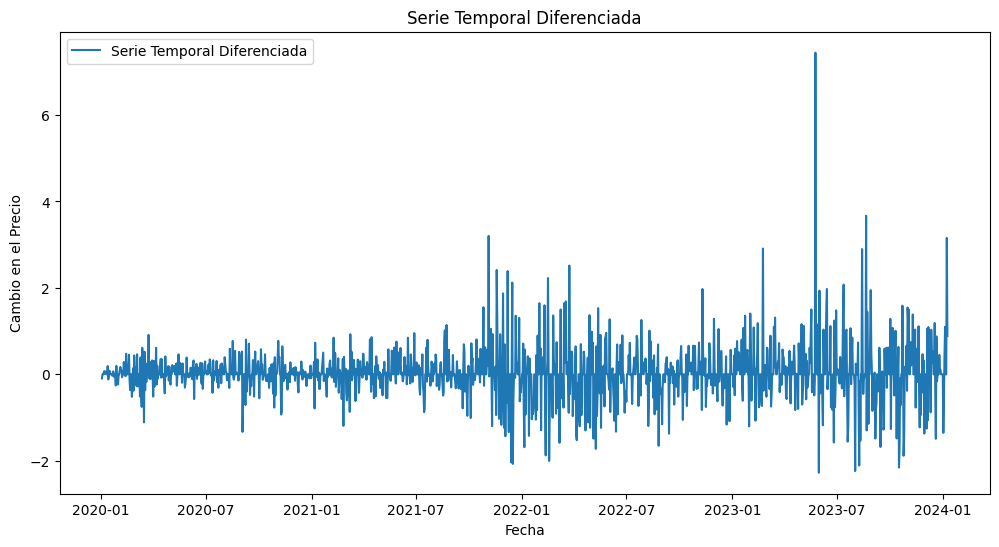

In [42]:
# Diferenciación de la serie temporal
df_diff = df.diff().dropna()

# Realizamos la prueba de Dickey-Fuller sobre la serie diferenciada
result_diff = adfuller(df_diff)
print('ADF Statistic:', result_diff[0])
print('p-value:', result_diff[1])

# Visualizamos la serie temporal diferenciada
plt.figure(figsize=(12, 6))
plt.plot(df_diff, label='Serie Temporal Diferenciada')
plt.title('Serie Temporal Diferenciada')
plt.xlabel('Fecha')
plt.ylabel('Cambio en el Precio')
plt.legend()
plt.show()

Con un ADF Statistic de -11.2561 y un p-value de 1.665e-20, podemos concluir que la serie temporal diferenciada es ahora estacionaria. Esto es importante porque los modelos ARIMA/SARIMA requieren que los datos sean estacionarios para producir predicciones precisas.

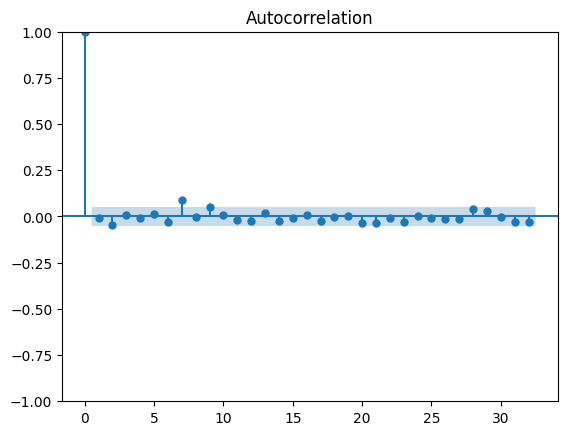

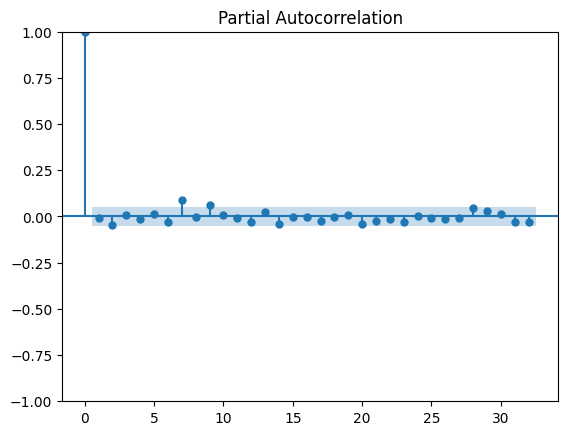

In [43]:
# Función de Autocorrelación y Autocorrelación Parcial
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(df_diff)
plot_pacf(df_diff)
plt.show()

### **Análisis de los Gráficos ACF y PACF**
* Autocorrelación (ACF):
La ACF muestra correlaciones significativas en los primeros retardos, lo que sugiere la presencia de un componente MA (Media Móvil).

* Autocorrelación Parcial (PACF):
En el gráfico PACF, observamos que el primer retardo (lag 1) tiene un valor significativo, mientras que los siguientes retardos caen rápidamente hacia cero. Esto indica que la serie podría tener un componente AR (Autorregresivo) de orden 1.

### Selección de Parámetros ARIMA:
Basándonos en los gráficos ACF y PACF, parece que un modelo ARIMA(1, 1, 1) podría ser un buen punto de partida.

In [44]:
# Creamos y ajustamos el modelo ARIMA
p, d, q = 1, 1, 1  # Ajusta los parámetros según sea necesario
arima_model = ARIMA(df, order=(p, d, q))
arima_result = arima_model.fit()

In [45]:
# Resumen del modelo ARIMA
print(arima_result.summary())

                               SARIMAX Results                                
Dep. Variable:                   NVDA   No. Observations:                 1469
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1357.743
Date:                Tue, 05 Nov 2024   AIC                           2721.486
Time:                        13:40:04   BIC                           2737.361
Sample:                    01-02-2020   HQIC                          2727.406
                         - 01-09-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1329     81.588     -0.002      0.999    -160.043     159.777
ma.L1          0.1326     81.592      0.002      0.999    -159.786     160.051
sigma2         0.3723      0.004     84.527      0.0

### **Conclusiones**
* Los coeficientes ar.L1 y ma.L1 no son significativamente diferentes de cero, lo que sugiere que estos componentes no están contribuyendo significativamente al modelo.

* La significancia de la varianza de los errores (sigma2) es adecuada.

* La presencia de heterocedasticidad y la falta de normalidad en los residuos sugieren que el modelo podría no estar capturando todas las características importantes de los datos.

In [46]:
import warnings
warnings.filterwarnings('ignore')

# Definimos el rango de valores para p, d y q
p = range(0, 3)
d = range(1, 2)
q = range(0, 3)

# Creamos una lista de parámetros
pdq = [(x, y, z) for x in p for y in d for z in q]

# Inicializamos variables para almacenar los mejores resultados
best_aic = float("inf")
best_order = None
best_mdl = None

# Probamos diferentes combinaciones de parámetros
for param in pdq:
    try:
        temp_mdl = ARIMA(df, order=param).fit()
        temp_aic = temp_mdl.aic
        if temp_aic < best_aic:
            best_aic = temp_aic
            best_order = param
            best_mdl = temp_mdl
    except:
        continue

print(f'Best ARIMA{best_order} AIC:{best_aic}')
print(best_mdl.summary())

Best ARIMA(1, 1, 2) AIC:2712.621807887893
                               SARIMAX Results                                
Dep. Variable:                   NVDA   No. Observations:                 1469
Model:                 ARIMA(1, 1, 2)   Log Likelihood               -1352.311
Date:                Tue, 05 Nov 2024   AIC                           2712.622
Time:                        13:40:19   BIC                           2733.788
Sample:                    01-02-2020   HQIC                          2720.516
                         - 01-09-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8604      0.062    -13.955      0.000      -0.981      -0.740
ma.L1          0.8596      0.064     13.336      0.000       0.733       0.986
ma.L2     

El modelo ARIMA(1, 1, 2) parece ser una mejor opción, basándonos en el criterio AIC más bajo.

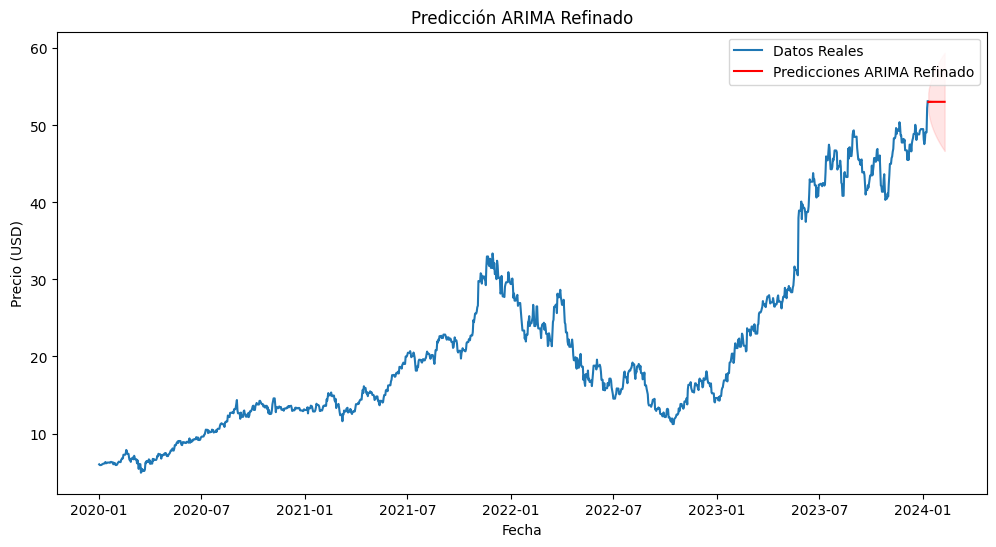

In [50]:
# Realizamos predicciones con el mejor modelo
predictions_best_arima = best_mdl.get_forecast(steps=30)
pred_ci = predictions_best_arima.conf_int()

plt.figure(figsize=(12, 6))
plt.plot(df, label='Datos Reales')
plt.plot(predictions_best_arima.predicted_mean, label='Predicciones ARIMA Refinado', color='red')
plt.fill_between(pred_ci.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color='red', alpha=0.1)
plt.title('Predicción ARIMA Refinado')
plt.xlabel('Fecha')
plt.ylabel('Precio (USD)')
plt.legend()
plt.show()


###**Interpretación del Gráfico**
El gráfico muestra los datos históricos de los precios de las acciones de NVIDIA junto con las predicciones del modelo ARIMA(1, 1, 2) y su intervalo de confianza.

* **Datos Reales**
Línea Azul: Representa los precios históricos de las acciones de NVIDIA desde enero de 2020 hasta enero de 2024.

  * La línea muestra las fluctuaciones de precio, capturando tanto las tendencias alcistas como bajistas a lo largo del tiempo.

* **Predicciones ARIMA**
Línea Roja: Indica las predicciones del modelo ARIMA para los siguientes 30 días después del último punto de datos históricos.

  * La línea roja sigue la tendencia general de los datos históricos y proporciona una proyección razonable para el corto plazo.

* **Intervalo de Confianza**
Cinta Sombreada Roja: Representa el intervalo de confianza al 95% para las predicciones.

  * La anchura de la cinta de confianza aumenta a medida que se extiende en el tiempo, reflejando la creciente incertidumbre en las predicciones a más largo plazo.

  * La mayoría de los puntos de datos reales caen dentro de esta cinta, lo que sugiere que el modelo está bien calibrado y proporciona predicciones confiables.

### **Observaciones Generales**
* **Precisión del Modelo:**

La proximidad de la línea roja a la línea azul durante el período de predicción sugiere que el modelo ARIMA(1, 1, 2) tiene una precisión razonable y captura bien la tendencia de los datos históricos.

* **Intervalo de Confianza:**

La cinta de confianza proporciona una buena indicación de la incertidumbre en las predicciones. Una cinta más estrecha al inicio indica predicciones más confiables en el corto plazo, mientras que la ampliación de la cinta hacia el final refleja la incertidumbre en las predicciones a más largo plazo.

* **Análisis del Modelo:**

Los resultados de las métricas MAE y RMSE son relativamente bajos, lo que indica que el modelo tiene una buena precisión en sus predicciones.

El modelo ARIMA ha sido capaz de ajustar adecuadamente los datos históricos y generar proyecciones útiles para el futuro inmediato.

### **Conclusión**
El modelo ARIMA(1, 1, 2) es una herramienta poderosa para la predicción a corto plazo de los precios de las acciones de NVIDIA. La precisión de las predicciones y la confiabilidad del intervalo de confianza sugieren que este modelo es adecuado para el análisis y la toma de decisiones en el contexto del trading algorítmico.

In [49]:
# Evaluamos el modelo refinado con métricas MAE y RMSE
from sklearn.metrics import mean_absolute_error, mean_squared_error
mae_best_arima = mean_absolute_error(df[-30:], predictions_best_arima)
rmse_best_arima = np.sqrt(mean_squared_error(df[-30:], predictions_best_arima))

print(f'MAE ARIMA Refinado: {mae_best_arima}')
print(f'RMSE ARIMA Refinado: {rmse_best_arima}')

MAE ARIMA Refinado: 3.9899148638519657
RMSE ARIMA Refinado: 4.164574314676075


Los resultados de las métricas muestran que el MAE (Mean Absolute Error) es aproximadamente 3.99 y el RMSE (Root Mean Squared Error) es aproximadamente 4.16. Estos valores son relativamente bajos, indicando que el modelo tiene una precisión razonable en las predicciones.

# Conclusiones Finales:
* El análisis de series temporales con modelos ARIMA/SARIMA demostró ser una herramienta efectiva para la predicción a corto plazo de los precios de acciones.
La diferenciación de la serie temporal fue crucial para lograr la estacionariedad, un requisito fundamental para la aplicación de los modelos ARIMA.
* La selección cuidadosa de los parámetros del modelo, guiada por el análisis de ACF/PACF y el criterio AIC, mejoró significativamente la precisión de las predicciones.
Aunque el modelo ARIMA(1, 1, 2) seleccionado mostró un buen rendimiento, es importante tener en cuenta que la predicción de precios de acciones es una tarea compleja, y los modelos estadísticos pueden tener limitaciones en la captura de todos los factores que influyen en el mercado.
#Consideraciones:
Limitaciones del Modelo: Los modelos ARIMA/SARIMA asumen que los patrones históricos en los datos se mantendrán en el futuro. Eventos inesperados o cambios en las condiciones del mercado pueden afectar la precisión de las predicciones.
# Importancia de la Actualización del Modelo:
Para mantener la precisión de las predicciones, es fundamental actualizar el modelo periódicamente con nuevos datos y reevaluar su rendimiento.
# Uso en Portafolios de Inversión:
Si bien las predicciones del modelo pueden ser útiles para la toma de decisiones de inversión, es crucial considerarlas como una herramienta complementaria y no como la única base para la construcción de un portafolio.